# Statistical Analysis of Basic Baskets

In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_excel('data/ICB_2s-2025.xlsx')
df

,Data_Coleta,Estabelecimento,Produto,Marca,Preco,Quantidade,PPK
0,2022-09-12,SUP-0,Leite,Parmalat,6.28,1.0,6.280000
1,2022-09-12,SUP-1,Tomate,NaN,6.99,1.0,6.990000
2,2022-09-12,SUP-2,Arroz,Namorado,17.98,5.0,3.596000
3,2022-09-12,SUP-2,Arroz,Broto Legal,22.69,5.0,4.538000
4,2022-09-12,SUP-0,Feijão,Broto Legal,10.98,1.0,10.980000
...,...,...,...,...,...,...,...
34027,2025-09-22,SUP-2,Manteiga,Outro,17.99,0.2,89.950000
34028,2025-09-22,SUP-0,Café,Caboclo,29.95,0.5,59.900000
34029,2025-09-22,SUP-2,Leite,Ninho,7.99,1.0,7.990000
34030,2025-09-22,SUP-0,Arroz,Empório São João,29.99,5.0,5.998000


## Data Overview

In [20]:
# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
df.isnull().sum()

Dataset Shape: (34032, 7)

First few rows:
  Data_Coleta Estabelecimento Produto        Marca  Preco  Quantidade     PPK
0  2022-09-12           SUP-0   Leite     Parmalat   6.28         1.0   6.280
1  2022-09-12           SUP-1  Tomate          NaN   6.99         1.0   6.990
2  2022-09-12           SUP-2   Arroz     Namorado  17.98         5.0   3.596
3  2022-09-12           SUP-2   Arroz  Broto Legal  22.69         5.0   4.538
4  2022-09-12           SUP-0  Feijão  Broto Legal  10.98         1.0  10.980

Data Types:
Data_Coleta        datetime64[ns]
Estabelecimento            object
Produto                    object
Marca                      object
Preco                     float64
Quantidade                float64
PPK                       float64
dtype: object

Missing Values:


Data_Coleta           0
Estabelecimento       0
Produto               0
Marca              6395
Preco                 0
Quantidade            0
PPK                   0
dtype: int64

## Descriptive Statistics

In [13]:
# Get descriptive statistics for numerical columns
print("Descriptive Statistics:")
print(df.describe())
print("\n\nAdditional Statistics:")
print("\nSkewness:")
print(df.skew(numeric_only=True))
print("\nKurtosis:")
print(df.kurtosis(numeric_only=True))

Descriptive Statistics:
                         Data_Coleta         Preco    Quantidade           PPK
count                          34032  34032.000000  34032.000000  34032.000000
mean   2024-04-02 13:55:46.121297664     13.780066      1.379653     19.659848
min              2022-09-12 00:00:00      1.190000      0.200000      0.449500
25%              2023-06-20 00:00:00      5.900000      0.900000      5.583000
50%              2024-04-10 00:00:00      8.990000      1.000000      7.655556
75%              2025-01-20 00:00:00     18.380000      1.000000     29.960000
max              2025-09-22 00:00:00     64.990000     60.000000    147.500000
std                              NaN     10.581267      1.662825     22.913911


Additional Statistics:

Skewness:
Preco         1.375224
Quantidade    4.655291
PPK           1.562501
dtype: float64

Kurtosis:
Preco          1.263909
Quantidade    64.644844
PPK            1.221821
dtype: float64


## Correlation Analysis

In [14]:
# Calculate correlation matrix for numerical columns
corr_matrix = df.corr(numeric_only=True)
print("Correlation Matrix:")
print(corr_matrix)

Correlation Matrix:
               Preco  Quantidade       PPK
Preco       1.000000    0.393774  0.411786
Quantidade  0.393774    1.000000 -0.350222
PPK         0.411786   -0.350222  1.000000


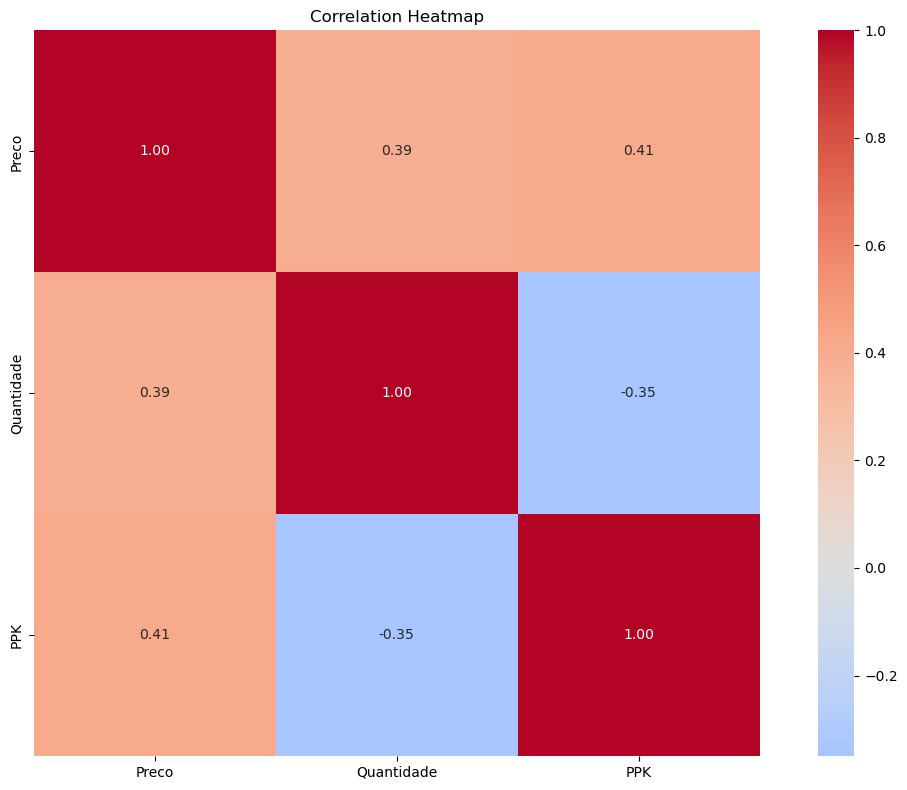

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

## Distribution Analysis

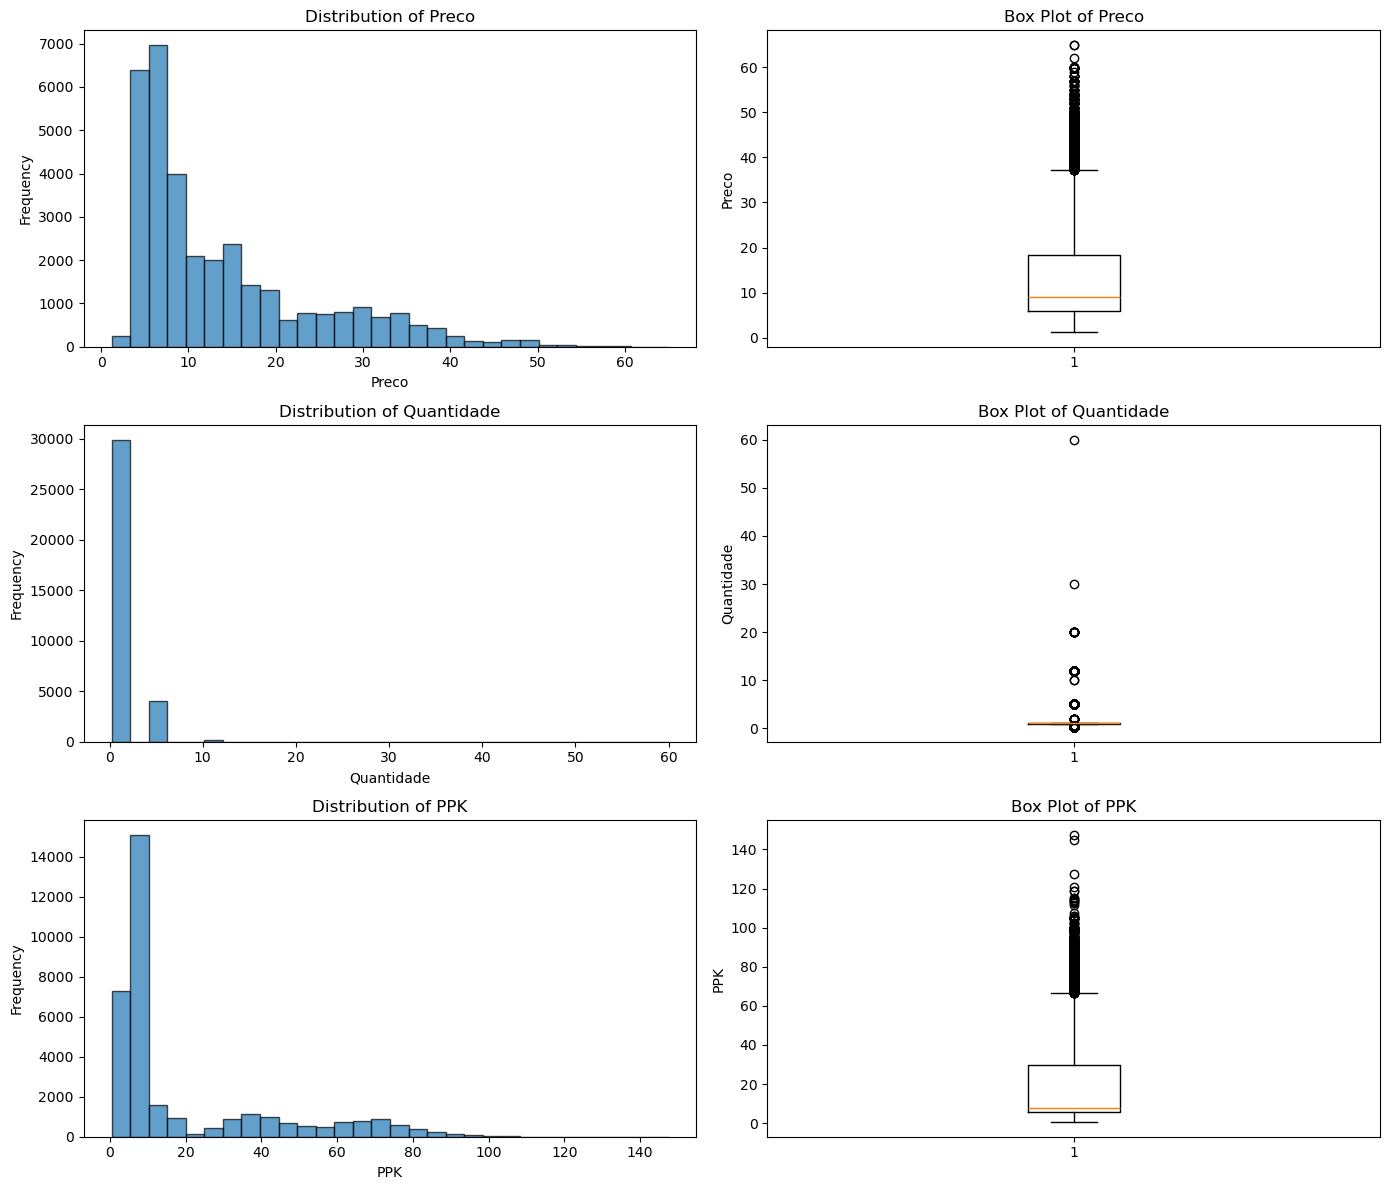

In [16]:
# Get numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns

# Create histograms and box plots for numerical columns
fig, axes = plt.subplots(len(numerical_cols), 2, figsize=(14, 4 * len(numerical_cols)))

for idx, col in enumerate(numerical_cols):
    # Histogram
    axes[idx, 0].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx, 0].set_title(f'Distribution of {col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    
    # Box plot
    axes[idx, 1].boxplot(df[col].dropna())
    axes[idx, 1].set_title(f'Box Plot of {col}')
    axes[idx, 1].set_ylabel(col)

plt.tight_layout()
plt.show()

## Summary

In [17]:
# Create a summary report
print("="*60)
print("STATISTICAL ANALYSIS SUMMARY")
print("="*60)
print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nNumerical Columns: {len(numerical_cols)}")
print(f"Categorical Columns: {len(df.select_dtypes(include=['object']).columns)}")
print(f"\nMissing Values: {df.isnull().sum().sum()}")
print(f"Percentage of Missing Data: {(df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100):.2f}%")

print("\n" + "="*60)
print("KEY STATISTICS FOR NUMERICAL COLUMNS")
print("="*60)
for col in numerical_cols:
    print(f"\n{col}:")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Median: {df[col].median():.2f}")
    print(f"  Std Dev: {df[col].std():.2f}")
    print(f"  Min: {df[col].min():.2f}")
    print(f"  Max: {df[col].max():.2f}")

STATISTICAL ANALYSIS SUMMARY

Dataset Shape: 34032 rows × 7 columns

Numerical Columns: 3
Categorical Columns: 3

Missing Values: 6395
Percentage of Missing Data: 2.68%

KEY STATISTICS FOR NUMERICAL COLUMNS

Preco:
  Mean: 13.78
  Median: 8.99
  Std Dev: 10.58
  Min: 1.19
  Max: 64.99

Quantidade:
  Mean: 1.38
  Median: 1.00
  Std Dev: 1.66
  Min: 0.20
  Max: 60.00

PPK:
  Mean: 19.66
  Median: 7.66
  Std Dev: 22.91
  Min: 0.45
  Max: 147.50


In [21]:
df.head()

,Data_Coleta,Estabelecimento,Produto,Marca,Preco,Quantidade,PPK
0,2022-09-12,SUP-0,Leite,Parmalat,6.28,1.0,6.280
1,2022-09-12,SUP-1,Tomate,NaN,6.99,1.0,6.990
2,2022-09-12,SUP-2,Arroz,Namorado,17.98,5.0,3.596
3,2022-09-12,SUP-2,Arroz,Broto Legal,22.69,5.0,4.538
4,2022-09-12,SUP-0,Feijão,Broto Legal,10.98,1.0,10.980


In [22]:
outliers = pd.DataFrame()
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_condition = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers_col = df.loc[outlier_condition, col]
    outliers = pd.concat([outliers, outliers_col], axis=1)
outliers

,Preco,Quantidade,PPK
11,42.90,NaN,NaN
13,42.93,NaN,NaN
33,51.90,NaN,NaN
121,53.90,NaN,NaN
155,37.90,0.5,75.80
...,...,...,...
34016,NaN,5.0,NaN
34026,NaN,0.2,89.95
34027,NaN,0.2,89.95
34028,NaN,0.5,NaN


In [39]:
manteiga

,Data_Coleta,Estabelecimento,Produto,Marca,Preco,Quantidade,PPK
7,2022-09-12,SUP-4,Manteiga,Qualy,10.98,0.5,21.96
19,2022-09-12,SUP-0,Manteiga,Prato Fino,9.00,0.5,18.00
30,2022-09-12,SUP-1,Manteiga,Doriana,9.98,0.5,19.96
35,2022-09-12,SUP-3,Manteiga,Prato Fino,7.89,0.5,15.78
36,2022-09-12,SUP-3,Manteiga,Qualy,10.79,0.5,21.58
...,...,...,...,...,...,...,...
33995,2025-09-22,SUP-0,Manteiga,Batavo,14.35,0.2,71.75
34009,2025-09-22,SUP-0,Manteiga,Aviação,13.95,0.2,69.75
34010,2025-09-22,SUP-2,Manteiga,Itambé,11.60,0.2,58.00
34026,2025-09-22,SUP-2,Manteiga,Aviação,17.99,0.2,89.95


In [ ]:
df.groupby('Produto')

AttributeError: 'DataFrameGroupBy' object has no attribute 'length'

In [41]:
manteiga = df[df['Produto'] == 'Manteiga']
manteiga.groupby('Marca')['PPK'].mean()

Marca
Aviação            77.685152
Batavo             62.624400
Bela Nata          51.500000
Brasileirissima    67.450000
Carrefour          54.282500
Catupiry           35.705000
Claybom            17.423333
Cruzilia           52.450000
Da Vaca            58.893864
DaVaca             67.425070
Danone             66.085567
Davaca             63.046000
Delícia            17.840000
Dia                59.565000
Doriana            34.943750
Dualis             27.600000
Elegê              57.945556
Frimesa            63.831129
Itambé             63.802148
Leco               67.053333
Líder              27.000000
Matilat            67.634375
Mimosa             54.950000
Outro              66.667096
Outro2             69.950000
Piracanjuba        69.797333
Piracanjuba        60.750000
Porto Alegre       49.955000
Prato Fino         16.890000
President          70.588644
Qualita            63.550000
Qualitá            61.950000
Qualy              64.295278
Regina             67.650000
Reliquia

## Distinct Products Count

In [47]:
# Count total distinct products
total_distinct_products = df['Produto'].nunique()
print(f"Total de produtos distintos: {total_distinct_products}")

# Show all distinct products
print(f"\nProdutos encontrados:")
distinct_products = df['Produto'].unique()
for i, produto in enumerate(distinct_products, 1):
    print(f"{i}. {produto}")


Total de produtos distintos: 27

Produtos encontrados:
1. Leite
2. Tomate
3. Arroz
4. Feijão
5. Açúcar
6. Manteiga
7. Óleo
8. Carne Coxão Mole
9. Café
10. Banana Prata
11. Farinha
12. Batata
13. Banana Nanica
14. Pão
15. Frango Peito
16. Macarrão
17. Carne Pernil
18. Ovo
19. Carne Acém
20. Frango Sobrecoxa
21. Carne Acem
22. Farinha de Trigo
23. Macarrão com Ovos
24. Pão Francês
25. Carne Bovina Acem
26. Carne Bovina Coxão Mole
27. Carne Suína Pernil


In [50]:
mapping = {k: "Carne Bovina Acém" for k in ['Carne Acém', 'Carne Acem', 'Carne Bovina Acem']}

In [51]:
acem = df['Produto'].replace(mapping)

In [55]:
distintos = acem.unique()
distintos

array(['Leite', 'Tomate', 'Arroz', 'Feijão', 'Açúcar', 'Manteiga', 'Óleo',
       'Carne Coxão Mole', 'Café', 'Banana Prata', 'Farinha', 'Batata',
       'Banana Nanica', 'Pão', 'Frango Peito', 'Macarrão', 'Carne Pernil',
       'Ovo', 'Carne Bovina Acém', 'Frango Sobrecoxa', 'Farinha de Trigo',
       'Macarrão com Ovos', 'Pão Francês', 'Carne Bovina Coxão Mole',
       'Carne Suína Pernil'], dtype=object)